## STEP06.Streamlit 앱 생성

Python SDK로 서비스를 쿼리(snowflake Python 패키지 사용)할 수 있습니다. 이 자습서에서는 Streamlit in Snowflake 애플리케이션에서 Python SDK를 사용하는 방법을 보여줍니다.   

먼저 서비스 생성 단계에서 전역 Snowsight UI 역할이 서비스를 생성하는 데 사용된 역할과 동일한지 확인합니다.   

1. Snowsight 에 로그인합니다.

2. 왼쪽 탐색 메뉴에서 **Projects » Streamlit** 를 선택합니다.

3. **+ Streamlit App** 를 선택합니다.

4. 중요: 앱 위치에 대한 cortex_search_tutorial_db 데이터베이스와 public 스키마를 선택합니다.

5. Streamlit in Snowflake 편집기의 왼쪽 창에서 **Packages** 를 선택하고 snowflake (버전 >= 0.8.0)를 추가하여 애플리케이션에 패키지를 설치합니다.

6. 예제 애플리케이션 코드를 다음 Streamlit 앱으로 바꿉니다.

In [ ]:
import streamlit as st
from snowflake.core import Root # requires snowflake>=0.8.0
from snowflake.cortex import Complete
from snowflake.snowpark.context import get_active_session

MODELS = [
    "mistral-large",
    "snowflake-arctic",
    "llama3-70b",
    "llama3-8b",
]

def init_messages():
    """
    Initialize the session state for chat messages. If the session state indicates that the
    conversation should be cleared or if the "messages" key is not in the session state,
    initialize it as an empty list.
    """
    if st.session_state.clear_conversation or "messages" not in st.session_state:
        st.session_state.messages = []


def init_service_metadata():
    """
    Initialize the session state for cortex search service metadata. Query the available
    cortex search services from the Snowflake session and store their names and search
    columns in the session state.
    """
    if "service_metadata" not in st.session_state:
        services = session.sql("SHOW CORTEX SEARCH SERVICES;").collect()
        service_metadata = []
        if services:
            for s in services:
                svc_name = s["name"]
                svc_search_col = session.sql(
                    f"DESC CORTEX SEARCH SERVICE {svc_name};"
                ).collect()[0]["search_column"]
                service_metadata.append(
                    {"name": svc_name, "search_column": svc_search_col}
                )

        st.session_state.service_metadata = service_metadata


def init_config_options():
    """
    Initialize the configuration options in the Streamlit sidebar. Allow the user to select
    a cortex search service, clear the conversation, toggle debug mode, and toggle the use of
    chat history. Also provide advanced options to select a model, the number of context chunks,
    and the number of chat messages to use in the chat history.
    """
    st.sidebar.selectbox(
        "Select cortex search service:",
        [s["name"] for s in st.session_state.service_metadata],
        key="selected_cortex_search_service",
    )

    st.sidebar.button("Clear conversation", key="clear_conversation")
    st.sidebar.toggle("Debug", key="debug", value=False)
    st.sidebar.toggle("Use chat history", key="use_chat_history", value=True)

    with st.sidebar.expander("Advanced options"):
        st.selectbox("Select model:", MODELS, key="model_name")
        st.number_input(
            "Select number of context chunks",
            value=5,
            key="num_retrieved_chunks",
            min_value=1,
            max_value=10,
        )
        st.number_input(
            "Select number of messages to use in chat history",
            value=5,
            key="num_chat_messages",
            min_value=1,
            max_value=10,
        )

    st.sidebar.expander("Session State").write(st.session_state)


def query_cortex_search_service(query, columns = [], filter={}):
    """
    Query the selected cortex search service with the given query and retrieve context documents.
    Display the retrieved context documents in the sidebar if debug mode is enabled. Return the
    context documents as a string.

    Args:
        query (str): The query to search the cortex search service with.

    Returns:
        str: The concatenated string of context documents.
    """
    db, schema = session.get_current_database(), session.get_current_schema()

    cortex_search_service = (
        root.databases[db]
        .schemas[schema]
        .cortex_search_services[st.session_state.selected_cortex_search_service]
    )

    context_documents = cortex_search_service.search(
        query, columns=columns, filter=filter, limit=st.session_state.num_retrieved_chunks
    )
    results = context_documents.results

    service_metadata = st.session_state.service_metadata
    search_col = [s["search_column"] for s in service_metadata
                    if s["name"] == st.session_state.selected_cortex_search_service][0].lower()

    context_str = ""
    for i, r in enumerate(results):
        context_str += f"Context document {i+1}: {r[search_col]} \n" + "\n"

    if st.session_state.debug:
        st.sidebar.text_area("Context documents", context_str, height=500)

    return context_str, results


def get_chat_history():
    """
    Retrieve the chat history from the session state limited to the number of messages specified
    by the user in the sidebar options.

    Returns:
        list: The list of chat messages from the session state.
    """
    start_index = max(
        0, len(st.session_state.messages) - st.session_state.num_chat_messages
    )
    return st.session_state.messages[start_index : len(st.session_state.messages) - 1]


def complete(model, prompt):
    """
    Generate a completion for the given prompt using the specified model.

    Args:
        model (str): The name of the model to use for completion.
        prompt (str): The prompt to generate a completion for.

    Returns:
        str: The generated completion.
    """
    return Complete(model, prompt).replace("$", "\$")


def make_chat_history_summary(chat_history, question):
    """
    Generate a summary of the chat history combined with the current question to extend the query
    context. Use the language model to generate this summary.

    Args:
        chat_history (str): The chat history to include in the summary.
        question (str): The current user question to extend with the chat history.

    Returns:
        str: The generated summary of the chat history and question.
    """
    prompt = f"""
        [INST]
        Based on the chat history below and the question, generate a query that extend the question
        with the chat history provided. The query should be in natural language.
        Answer with only the query. Do not add any explanation.

        <chat_history>
        {chat_history}
        </chat_history>
        <question>
        {question}
        </question>
        [/INST]
    """

    summary = complete(st.session_state.model_name, prompt)

    if st.session_state.debug:
        st.sidebar.text_area(
            "Chat history summary", summary.replace("$", "\$"), height=150
        )

    return summary


def create_prompt(user_question):
    """
    Create a prompt for the language model by combining the user question with context retrieved
    from the cortex search service and chat history (if enabled). Format the prompt according to
    the expected input format of the model.

    Args:
        user_question (str): The user's question to generate a prompt for.

    Returns:
        str: The generated prompt for the language model.
    """
    if st.session_state.use_chat_history:
        chat_history = get_chat_history()
        if chat_history != []:
            question_summary = make_chat_history_summary(chat_history, user_question)
            prompt_context, results = query_cortex_search_service(
                question_summary,
                columns=["chunk", "file_url", "relative_path"],
                filter={"@and": [{"@eq": {"language": "English"}}]},
            )
        else:
            prompt_context, results = query_cortex_search_service(
                user_question,
                columns=["chunk", "file_url", "relative_path"],
                filter={"@and": [{"@eq": {"language": "English"}}]},
            )
    else:
        prompt_context, results = query_cortex_search_service(
            user_question,
            columns=["chunk", "file_url", "relative_path"],
            filter={"@and": [{"@eq": {"language": "English"}}]},
        )
        chat_history = ""

    prompt = f"""
            [INST]
            You are a helpful AI chat assistant with RAG capabilities. When a user asks you a question,
            you will also be given context provided between <context> and </context> tags. Use that context
            with the user's chat history provided in the between <chat_history> and </chat_history> tags
            to provide a summary that addresses the user's question. Ensure the answer is coherent, concise,
            and directly relevant to the user's question.

            If the user asks a generic question which cannot be answered with the given context or chat_history,
            just say "I don't know the answer to that question.

            Don't saying things like "according to the provided context".

            <chat_history>
            {chat_history}
            </chat_history>
            <context>
            {prompt_context}
            </context>
            <question>
            {user_question}
            </question>
            [/INST]
            Answer:
            """
    return prompt, results


def main():
    st.title(f":speech_balloon: Chatbot with Snowflake Cortex")

    init_service_metadata()
    init_config_options()
    init_messages()

    icons = {"assistant": "❄️", "user": "👤"}

    # Display chat messages from history on app rerun
    for message in st.session_state.messages:
        with st.chat_message(message["role"], avatar=icons[message["role"]]):
            st.markdown(message["content"])

    disable_chat = (
        "service_metadata" not in st.session_state
        or len(st.session_state.service_metadata) == 0
    )
    if question := st.chat_input("Ask a question...", disabled=disable_chat):
        # Add user message to chat history
        st.session_state.messages.append({"role": "user", "content": question})
        # Display user message in chat message container
        with st.chat_message("user", avatar=icons["user"]):
            st.markdown(question.replace("$", "\$"))

        # Display assistant response in chat message container
        with st.chat_message("assistant", avatar=icons["assistant"]):
            message_placeholder = st.empty()
            question = question.replace("'", "")
            prompt, results = create_prompt(question)
            with st.spinner("Thinking..."):
                generated_response = complete(
                    st.session_state.model_name, prompt
                )
                # build references table for citation
                markdown_table = "###### References \n\n| PDF Title | URL |\n|-------|-----|\n"
                for ref in results:
                    markdown_table += f"| {ref['relative_path']} | [Link]({ref['file_url']}) |\n"
                message_placeholder.markdown(generated_response + "\n\n" + markdown_table)

        st.session_state.messages.append(
            {"role": "assistant", "content": generated_response}
        )


if __name__ == "__main__":
    session = get_active_session()
    root = Root(session)
    main()

## 앱 사용해 보기

Streamlit in Snowflake 편집기 창의 오른쪽 창에서 Streamlit 앱의 미리 보기를 볼 수 있습니다. 미리 보기는 다음 스크린샷과 유사해야 합니다.

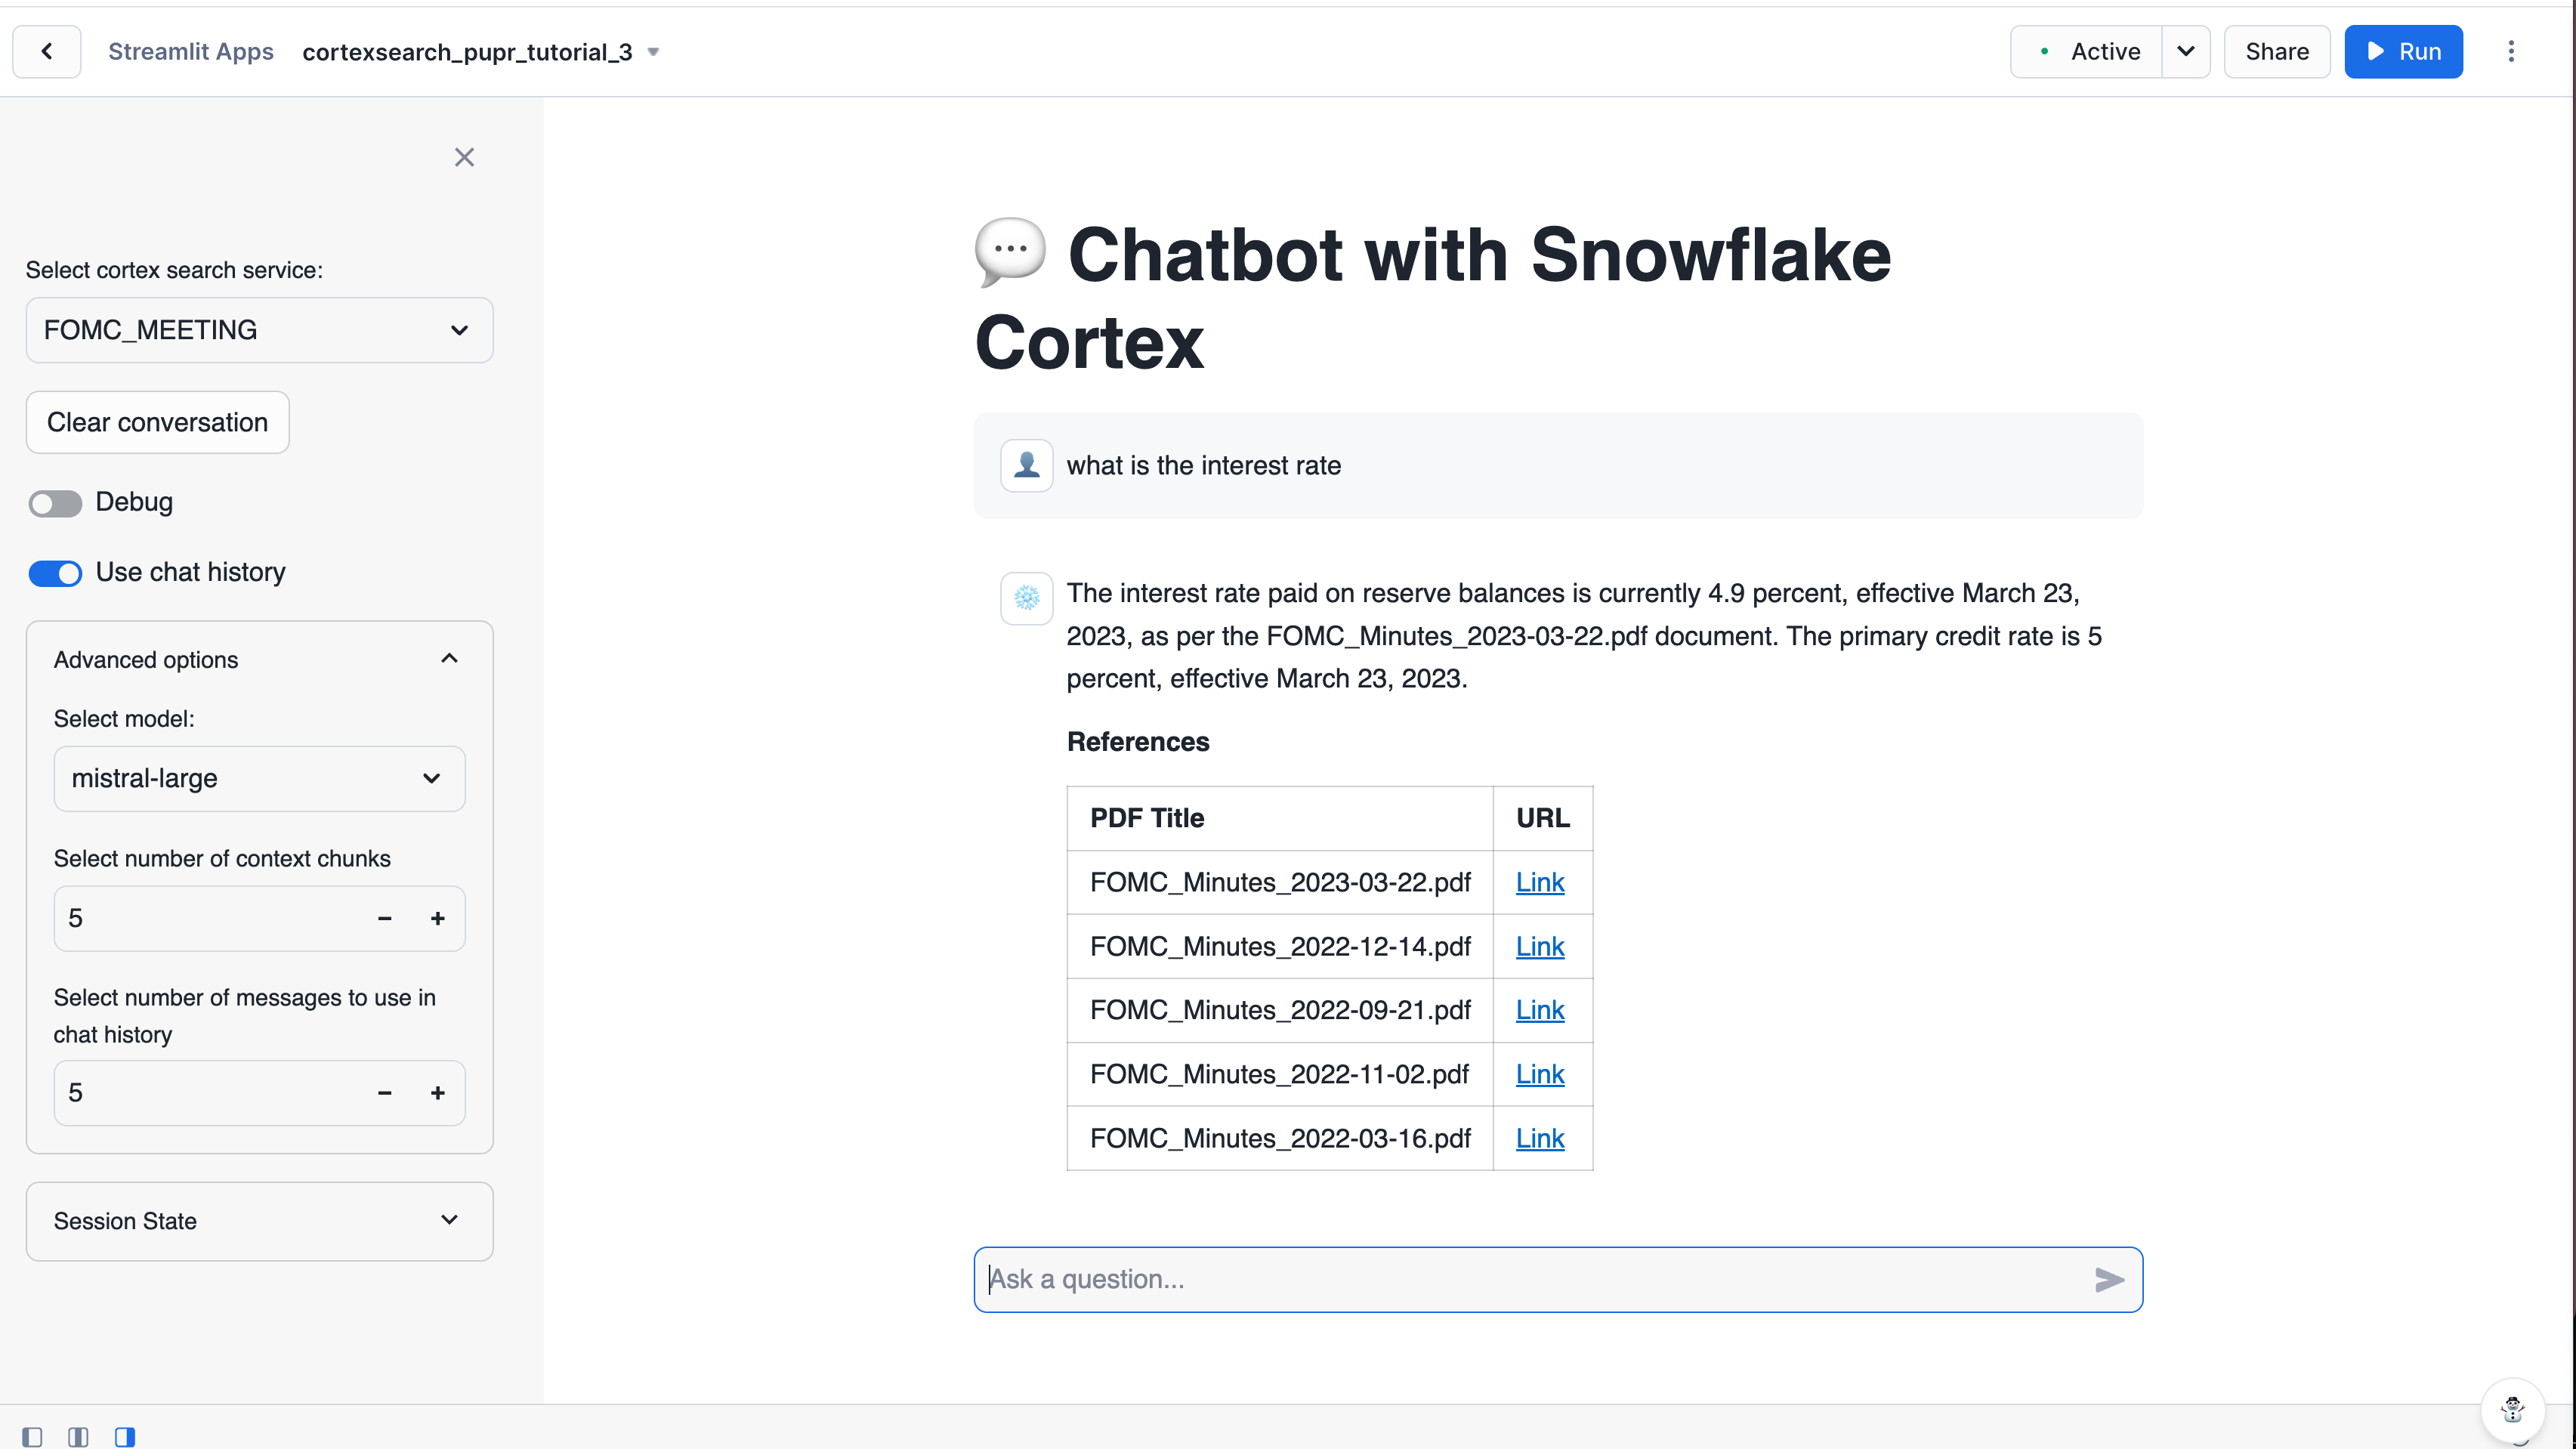

텍스트 상자에 질문을 입력하여 새 앱을 사용해 봅니다. 시도해 볼 수 있는 몇 가지 샘플 쿼리는 다음과 같습니다.

- 예제 세션 1: 질문과 답변을 여러 차례 주고받기
    - How was gpd growth in q4 23?
    - How was unemployment in the same quarter?

- 예제 세션 2: 여러 문서 요약
    - How has the fed's view of the market change over the course of 2024?

- 예제 세션 3: 문서에 정답이 포함되어 있지 않은 경우 기권하기
    - What was janet yellen's opinion about 2024 q1?